In [1]:
import numpy as np
import pandas as pd
import os
import csv
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [2]:
# Read in relevant data

quals = pd.read_csv('./kaggle_csvs/qualifying.csv')
drivers = pd.read_csv('./kaggle_csvs/drivers.csv')
races = pd.read_csv('./kaggle_csvs/races.csv')
lap_times = pd.read_csv('./kaggle_csvs/lap_times.csv')
lap_times = lap_times.sort_values(['raceId','driverId','lap'],ascending=[True,True,True])
pits = pd.read_csv('./kaggle_csvs/pit_stops.csv')
results = pd.read_csv('./kaggle_csvs/results.csv')
status = pd.read_csv('./kaggle_csvs/status.csv')

In [3]:
# Create Directories for Race Files

dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]
for index, row in races.iterrows():
    name = str(row['year']) + ' ' + str(row['name'])
    d_n = './races/' + name
    if name not in dirs:
        os.mkdir(d_n)

In [4]:
# Parse files for timing, places, and intervals

# list all directories
dirs = [name for name in os.listdir('./races/') if os.path.isdir(os.path.join('./races/', name))]

# set blank for writing to CSVs
times = []
racer = []
places = []
first = lap_times.iloc[0]
race = lap_times.iloc[0]['raceId']
last = lap_times.iloc[-1]['raceId']
race_row = races.loc[races['raceId'] == last]

# if the file does not already exist
if not os.path.exists("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item())):
    
    #for all laps
    for index, row in lap_times.iterrows():
        
        #if the first lap
        if row['lap'] == 1:

            if racer != []:
                times.append(racer)
                racer = []
                
            # add leading variables
            racer.append(row['raceId'])
            racer.append(row['driverId'])
            racer.append(drivers.loc[drivers['driverId'] == row['driverId']]['driverRef'].item())
            final_pos = results.loc[(results['raceId'] == race) & (results['driverId'] == row['driverId'])]
            racer.append(final_pos['constructorId'].item())
            racer.append(final_pos['positionOrder'].item())
            racer.append(final_pos['statusId'].item())
            st = status.loc[status['statusId'] == final_pos['statusId'].item()]
            racer.append(st['status'].item())
            racer.append(row['milliseconds'])
            header = ['raceId','driverId','driverRef','constructorId','positionOrder','statusId','status']
        
        # else, add the new lap
        else:
            racer.append(row['milliseconds']+racer[-1])
            
        # if the last lap has been completed, write to file
        if index == len(lap_times.index)-1 or lap_times.iloc[[index+1]]['raceId'].item() != race:
            
            # add relevant values to the total time lists
            race_row = races.loc[races['raceId'] == race]
            times.append(racer)
            total_times = pd.DataFrame(times)
            total_times = total_times.sort_values(7)
            total_times = total_times.drop(total_times.index[-1])
            
            # add headers for lap number and write
            for c in total_times.columns:
                if int(c) > 6:
                    header.append(int(c)-6)
            total_times.columns = header
            total_times.to_csv("./races/{} {}/total_times.csv".format(race_row['year'].item(),race_row['name'].item()))

            # for all times in total times, find the place of the driver and write
            for ind,r in total_times.iterrows():
                dr = [r['driverRef']]
                for c in total_times.columns:
                    if isinstance(c,int):
                        if r[c] != 0 and not pd.isna(r[c]):
                            dr.append(total_times[total_times[c]<r[c]].count()[c]+1)
                        else:
                            dr.append(0)
                places.append(dr)

            places = pd.DataFrame(places)
            places.to_csv("./races/{} {}/places.csv".format(race_row['year'].item(),race_row['name'].item()))

            #find the interval times and write
            intervals = np.array(total_times)
            for i in range(7,len(intervals[0])):
                intervals[:,i] -= np.nanmin(intervals[:,i])

            intervals = pd.DataFrame(intervals)
            intervals = intervals.drop(intervals.index[-1])
            intervals.to_csv("./races/{} {}/intervals.csv".format(race_row['year'].item(),race_row['name'].item()))

            # reset variables
            race = lap_times.iloc[[index+1]]['raceId'].item()
            times = []
            racer = []
            places = []
            
print('done')

done


In [5]:
#function for comparing two lists with positions and copying the positions between the two for sorting
def complists(l1,l2):
    
    #sort lists based on position
    l1 = l1.sort_values(4,ignore_index=True)
    l2 = l2.sort_values(4,ignore_index=True)
    d1 = l1.iloc[:,3]
    d2 = l2.iloc[:,3]
    
    # corrolate lists
    order = []
    for i,d in l1.iterrows():
        if d[3] in list(d2):
            order.append([d[0],d[1],d[2],d[3],d2[d2==d[3]].index.values[0],l1.loc[l1[3] == d[3], 3].iloc[0]])
    
    #return previous lap ordering with current positions
    order = pd.DataFrame(order)
    order = np.array(order)
    return order

In [6]:
def swap(arr,j,orders,qt,n_pass,v_pass,pit=False):
    
    n_laps = orders[arr[j][1]][3]
    
    if j == 0:
        orders[arr[j+1][1]] = [None,0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
    elif j == len(arr)-2:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,None,0]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
    else:
        orders[arr[j+1][1]] = [arr[j-1][3],0,arr[j][3],0]
        orders[arr[j][1]] = [arr[j+1][3],0,arr[j+2][3],0]
        behind = orders[arr[j+2][1]]
        orders[arr[j+2][1]] = [arr[j][3],0,behind[2],behind[3]]
        ahead = orders[arr[j-1][1]]
        orders[arr[j-1][1]] = [ahead[0],ahead[1],arr[j+1][3],0]
        
    if pit:
        arr[j], arr[j+1] = arr[j+1], arr[j]
        return
    
    if int(arr[j+1][1]) in qt[0].unique():
        tf = qt[qt[0] == int(arr[j+1][1])]
    elif int(arr[j+1][2]) in qt[1].unique():
        tf = qt[qt[1] == int(arr[j+1][2])]
    else:
        print('tf')
        return 0,0

    # set the time of the passed based on qualifying or a teammates qualification
    if int(arr[j][1]) in qt[0].unique():
        ts = qt[qt[0] == arr[j][1]]
    elif int(arr[j][2]) in qt[1].unique():
        ts = qt.loc[qt[1] == int(arr[j][2])]
    else:
        print('ts')
        return 0,0

    #convert to datetime
    qf = datetime.strptime(tf[2].item(), '%M:%S.%f')
    qs = datetime.strptime(ts[2].item(), '%M:%S.%f')
        
    f_laps = list(orders[arr[j+1][1]])
    s_laps = list(orders[arr[j][1]])

    v_f = v_pass[arr[j+1][3]]
    #should i be using a ratio or subtraction
    v_pass[arr[j+1][3]] = [round(v_f[0]+(1/(f_laps[1]+1)*(2**((qf-qs).total_seconds()/100))),5),v_f[1]]
    v_s = v_pass[arr[j][3]]
    #should i be using a ratio or subtraction
    v_pass[arr[j][3]] = [v_s[0],round(v_s[1]+(s_laps[3]+1)*2**((qs-qf).total_seconds()/100),5)]

    n_f = n_pass[arr[j+1][3]]
    n_pass[arr[j+1][3]] = [n_f[0]+1,n_f[1]]
    n_s = n_pass[arr[j][3]]
    n_pass[arr[j][3]] = [n_s[0],n_s[1]+1]
    arr[j], arr[j+1] = arr[j+1], arr[j]
    
    return (qs-qf).total_seconds()/100,n_laps

In [7]:
#bubble sort lists. Fast because mosly ordered. Makes tracking overtaking easy because of the bubble method
def bubbleSort(arr,n_pass,v_pass,qt,orders,pits):
    #set number of laps and set total overtakes to 0
    n = len(arr)
    ot = 0
    times = []
    
    #for each row, bubble sort
    for i in range(n):
        for j in range(0,n-1-i):
            #if the position is higher than the one below
            if arr[j][4] > arr[j+1][4]:
                if int(arr[j+1][1]) in pits or int(arr[j][1]) in pits:
                    diff = swap(arr,j,orders,qt,n_pass,v_pass,pit=True)
                else:
                    diff,laps = swap(arr,j,orders,qt,n_pass,v_pass)
                    ot += 1
                    times.append([diff,laps])
                
    return ot, times

In [8]:
def overtakes(filename,n_pass,v_pass,pits,quals,dr_o,dr_p,rm=True):
    if os.path.exists(filename):
        diffs = []
        print(filename)
        laptimes = pd.read_csv(filename)
        raceId = laptimes['raceId']
        if int(raceId[0]) > 840:
            driverId = laptimes['driverId']
            constructorId = laptimes['constructorId']
            racers = laptimes.iloc[:,3]
            prev = laptimes.iloc[:,8]
            prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            orders = {}
            for p in range(len(prev)):
                if p == 0:
                    orders[prev[1][p]] = [None,0,prev[1][p+1],0]
                elif p == len(prev)-1:
                    orders[prev[1][p]] = [prev[1][p-1],0,None,0]
                else:
                    orders[prev[1][p]] = [prev[1][p-1],0,prev[1][p+1],0]
            stops = pits.loc[pits['raceId'] == raceId[0]]
            qt = quals.loc[quals['raceId'] == raceId[0]]
            if qt.empty:
                return
            did = [list(qt['driverId']),list(qt['constructorId'])]
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].fillna('3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\N",'3:00.00')
            qt[['q1','q2','q3']] = qt[['q1','q2','q3']].replace(r"\\N",'3:00.00')
            did.append(list(qt[['q1','q2','q3']].dropna().min(axis=1)))
            did = list(map(list, zip(*did)))
            qt = pd.DataFrame(did)
            tot_ots = 0
            l_b = {}
            for r in laptimes['driverRef']:
                l_b[r] = []
            for c in laptimes.columns[8:]:
                times = laptimes[c]
                times = pd.concat([raceId,driverId,constructorId,racers,times],keys=[0,1,2,3,4],axis=1)
                times.dropna(subset = [4], inplace=True)
                pitted = []
                if rm:
                    if int(c)-1 in list(stops['lap']):
                        rows = stops[stops['lap'] == int(c)-1]
                        for i,r in rows.iterrows():
                            times = times[times[1] != r[1]]
                            prev = prev[prev[1] != r[1]]
                            pitted.append(r[1])
                changes = complists(prev,times)
                ots,diff = bubbleSort(changes,n_pass,v_pass,qt,orders,pitted)
                tot_ots += ots
                diffs = diffs + diff
                """
                for i in range(len(times.index)):
                    if i == len(times.index)-1:
                        t = times.iloc[i]
                        l = l_b[t[3]]
                        ods = orders[t[1]]
                        l.append([ods[1],ods[3]])
                        l_b[t[3]] = l
                        continue
                    f = times.iloc[i]
                    s = times.iloc[i+1]
                    if abs(f[4]-s[4])/1000 < 1:
                        odf = orders[f[1]]
                        ods = orders[s[1]]
                        orders[f[1]] = [odf[0],odf[1],odf[2],odf[3]+1]
                        orders[s[1]] = [ods[0],ods[1]+1,ods[2],ods[3]]
                    odf = orders[f[1]]
                    l = l_b[f[3]]
                    l.append([odf[1],odf[3]])
                    l_b[f[3]] = l
                """
                for ind,t in times.iterrows():
                    ods = orders[t[1]]
                    orders[t[1]] = [ods[0],ods[1]+1,ods[2],ods[3]+1]
                    l = l_b[t[3]]
                    l.append([ods[1]+1,ods[3]+1])
                    l_b[t[3]] = l
                #"""
                prev = laptimes[c]
                prev = pd.concat([raceId,driverId,constructorId,racers,prev],keys=[0,1,2,3,4],axis=1)
            with open('{}total_overtakes.txt'.format(filename[:-15]), 'w') as f:
                f.write('%d' % tot_ots)
            with open('{}laps.txt'.format(filename[:-15]), 'w') as convert_file:
                convert_file.write(json.dumps(l_b))
                
        return diffs

In [9]:
n_pass = {}
v_pass ={}
dr_o = {}
dr_p = {}
diffs = []
for r in drivers['driverRef']:
    n_pass[r] = [0,0]
    v_pass[r] = [0,0]
    dr_o[r] = []
    dr_p[r] = []
#print(1)
for d in dirs:
    diff = overtakes('./races/{}/total_times.csv'.format(d),n_pass,v_pass,pits,quals,dr_o,dr_p)
    if diff != None:
        diffs = diffs + diff

for k in list(n_pass.keys()):
    if n_pass[k] == [0,0]:
        n_pass.pop(k)
    if v_pass[k] == [0,0]:
        v_pass.pop(k)
    if dr_o[k] == []:
        dr_o.pop(k)
    if dr_p[k] == []:
        dr_p.pop(k)

./races/2005 San Marino Grand Prix/total_times.csv
./races/2015 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 San Marino Grand Prix/total_times.csv
./races/2000 Canadian Grand Prix/total_times.csv
./races/2018 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Monaco Grand Prix/total_times.csv
./races/2012 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Korean Grand Prix/total_times.csv
./races/2013 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 British Grand Prix/total_times.csv
./races/2009 Australian Grand Prix/total_times.csv
./races/2016 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Monaco Grand Prix/total_times.csv
./races/2014 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Chinese Grand Prix/total_times.csv
./races/2002 Brazilian Grand Prix/total_times.csv
./races/2018 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 British Grand Prix/total_times.csv
./races/2000 Brazilian Grand Prix/total_times.csv
./races/2008 British Grand Prix/total_times.csv
./races/2014 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 German Grand Prix/total_times.csv
./races/2003 Monaco Grand Prix/total_times.csv
./races/2007 Malaysian Grand Prix/total_times.csv
./races/1996 Italian Grand Prix/total_times.csv
./races/2001 European Grand Prix/total_times.csv
./races/2007 Turkish Grand Prix/total_times.csv
./races/2020 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 German Grand Prix/total_times.csv
./races/2021 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Spanish Grand Prix/total_times.csv
./races/2015 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Belgian Grand Prix/total_times.csv
./races/2014 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Chinese Grand Prix/total_times.csv
./races/2012 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1997 Australian Grand Prix/total_times.csv
./races/2004 Japanese Grand Prix/total_times.csv
./races/2007 Hungarian Grand Prix/total_times.csv
./races/1997 German Grand Prix/total_times.csv
./races/2014 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Hungarian Grand Prix/total_times.csv
./races/1997 Austrian Grand Prix/total_times.csv
./races/1997 Japanese Grand Prix/total_times.csv
./races/2012 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1997 Hungarian Grand Prix/total_times.csv
./races/2018 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 French Grand Prix/total_times.csv
./races/2018 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Canadian Grand Prix/total_times.csv
./races/2001 Japanese Grand Prix/total_times.csv
./races/2006 Turkish Grand Prix/total_times.csv
./races/2001 Malaysian Grand Prix/total_times.csv
./races/2013 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Australian Grand Prix/total_times.csv
./races/2018 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Canadian Grand Prix/total_times.csv
./races/2000 United States Grand Prix/total_times.csv
./races/2012 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 British Grand Prix/total_times.csv
./races/2003 Japanese Grand Prix/total_times.csv
./races/2005 French Grand Prix/total_times.csv
./races/2019 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Belgian Grand Prix/total_times.csv
./races/1999 Australian Grand Prix/total_times.csv
./races/1997 Canadian Grand Prix/total_times.csv
./races/2016 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Spanish Grand Prix/total_times.csv
./races/2005 British Grand Prix/total_times.csv
./races/2012 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Abu Dhabi Grand Prix/total_times.csv
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
ts
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
tf
tf
tf
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
ts
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
tf
./races/1996 British Grand Prix/total_times.csv
./races/2007 Spanish Grand Prix/total_times.csv
./races/2005 German Grand Prix/total_times.csv
./races/2019 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 United States Grand Prix/total_times.csv
./races/2001 San Marino Grand Prix/total_times.csv
./races/2002 Hungarian Grand Prix/total_times.csv
./races/2010 Belgian Grand Prix/total_times.csv
./races/2005 Brazilian Grand Prix/total_times.csv
./races/2001 Brazilian Grand Prix/total_times.csv
./races/2004 Spanish Grand Prix/total_times.csv
./races/2014 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 Malaysian Grand Prix/total_times.csv
./races/1997 Spanish Grand Prix/total_times.csv
./races/2009 Italian Grand Prix/total_times.csv
./races/2019 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Spanish Grand Prix/total_times.csv
./races/2014 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Brazilian Grand Prix/total_times.csv
./races/2017 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 French Grand Prix/total_times.csv
./races/2004 United States Grand Prix/total_times.csv
./races/2008 European Grand Prix/total_times.csv
./races/2005 Japanese Grand Prix/total_times.csv
./races/2016 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Malaysian Grand Prix/total_times.csv
./races/2020 Tuscan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Monaco Grand Prix/total_times.csv
./races/2012 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 British Grand Prix/total_times.csv
./races/1999 Hungarian Grand Prix/total_times.csv
./races/1996 Hungarian Grand Prix/total_times.csv
./races/2013 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Abu Dhabi Grand Prix/total_times.csv
./races/1997 San Marino Grand Prix/total_times.csv
./races/2010 Brazilian Grand Prix/total_times.csv
./races/2008 Spanish Grand Prix/total_times.csv
./races/2004 British Grand Prix/total_times.csv
./races/2012 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Malaysian Grand Prix/total_times.csv
./races/2005 Spanish Grand Prix/total_times.csv
./races/2011 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 British Grand Prix/total_times.csv
./races/2004 Hungarian Grand Prix/total_times.csv
./races/2006 European Grand Prix/total_times.csv
./races/2004 French Grand Prix/total_times.csv
./races/2010 German Grand Prix/total_times.csv
./races/2020 Emilia Romagna Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Italian Grand Prix/total_times.csv
./races/2017 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Australian Grand Prix/total_times.csv
./races/2006 Spanish Grand Prix/total_times.csv
./races/2006 Japanese Grand Prix/total_times.csv
./races/1997 European Grand Prix/total_times.csv
./races/2002 Spanish Grand Prix/total_times.csv
./races/2018 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Italian Grand Prix/total_times.csv
./races/2020 70th Anniversary Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Brazilian Grand Prix/total_times.csv
./races/1999 Italian Grand Prix/total_times.csv
./races/2019 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 British Grand Prix/total_times.csv
./races/1996 Australian Grand Prix/total_times.csv
./races/2020 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Malaysian Grand Prix/total_times.csv
./races/1999 San Marino Grand Prix/total_times.csv
./races/2018 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Japanese Grand Prix/total_times.csv
./races/2004 Malaysian Grand Prix/total_times.csv
./races/2009 Japanese Grand Prix/total_times.csv
./races/1996 Brazilian Grand Prix/total_times.csv
./races/2015 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Bahrain Grand Prix/total_times.csv
./races/2020 Sakhir Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Hungarian Grand Prix/total_times.csv
./races/2007 European Grand Prix/total_times.csv
./races/2019 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Bahrain Grand Prix/total_times.csv
./races/1996 Argentine Grand Prix/total_times.csv
./races/2005 United States Grand Prix/total_times.csv
./races/2010 Abu Dhabi Grand Prix/total_times.csv
./races/2007 Bahrain Grand Prix/total_times.csv
./races/2012 European Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Styrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 European Grand Prix/total_times.csv
./races/2013 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Australian Grand Prix/total_times.csv
./races/2004 Canadian Grand Prix/total_times.csv
./races/2000 Spanish Grand Prix/total_times.csv
./races/2000 Japanese Grand Prix/total_times.csv
./races/2013 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Chinese Grand Prix/total_times.csv
./races/2002 British Grand Prix/total_times.csv
./races/2016 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 European Grand Prix/total_times.csv
./races/2003 Canadian Grand Prix/total_times.csv
./races/2012 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1997 Monaco Grand Prix/total_times.csv
./races/2012 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Japanese Grand Prix/total_times.csv
./races/2016 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 French Grand Prix/total_times.csv
./races/2018 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 Bahrain Grand Prix/total_times.csv
./races/2010 Singapore Grand Prix/total_times.csv
./races/2012 Indian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 German Grand Prix/total_times.csv
./races/2000 German Grand Prix/total_times.csv
./races/2021 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Italian Grand Prix/total_times.csv
./races/2016 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Hungarian Grand Prix/total_times.csv
./races/2014 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Japanese Grand Prix/total_times.csv
./races/2016 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 German Grand Prix/total_times.csv
./races/2020 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Turkish Grand Prix/total_times.csv
./races/2003 United States Grand Prix/total_times.csv
./races/2020 Eifel Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Turkish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Austrian Grand Prix/total_times.csv
./races/2011 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 European Grand Prix/total_times.csv
./races/2017 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 German Grand Prix/total_times.csv
./races/2004 Belgian Grand Prix/total_times.csv
./races/2012 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 Austrian Grand Prix/total_times.csv
./races/2002 Monaco Grand Prix/total_times.csv
./races/2007 Belgian Grand Prix/total_times.csv
./races/2020 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Italian Grand Prix/total_times.csv
./races/1997 French Grand Prix/total_times.csv
./races/2002 Malaysian Grand Prix/total_times.csv
./races/2015 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 French Grand Prix/total_times.csv
./races/2004 German Grand Prix/total_times.csv
./races/2008 Hungarian Grand Prix/total_times.csv
./races/2009 German Grand Prix/total_times.csv
./races/2010 Hungarian Grand Prix/total_times.csv
./races/2011 Turkish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Chinese Grand Prix/total_times.csv
./races/1998 Spanish Grand Prix/total_times.csv
./races/2012 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 French Grand Prix/total_times.csv
./races/2012 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 French Grand Prix/total_times.csv
./races/2001 Monaco Grand Prix/total_times.csv
./races/2012 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Malaysian Grand Prix/total_times.csv
./races/1997 Italian Grand Prix/total_times.csv
./races/2019 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Malaysian Grand Prix/total_times.csv
./races/2014 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Australian Grand Prix/total_times.csv
./races/2000 Monaco Grand Prix/total_times.csv
./races/1999 Monaco Grand Prix/total_times.csv
./races/1996 Japanese Grand Prix/total_times.csv
./races/2015 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Italian Grand Prix/total_times.csv
./races/2003 European Grand Prix/total_times.csv
./races/2003 French Grand Prix/total_times.csv
./races/2007 Japanese Grand Prix/total_times.csv
./races/2011 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 San Marino Grand Prix/total_times.csv
./races/2008 Italian Grand Prix/total_times.csv
./races/2009 Hungarian Grand Prix/total_times.csv
./races/2017 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Austrian Grand Prix/total_times.csv
./races/2005 European Grand Prix/total_times.csv
./races/2004 Italian Grand Prix/total_times.csv
./races/1999 Canadian Grand Prix/total_times.csv
./races/1997 Brazilian Grand Prix/total_times.csv
./races/2008 Australian Grand Prix/total_times.csv
./races/2000 French Grand Prix/total_times.csv
./races/2010 Spanish Grand Prix/total_times.csv
./races/2005 Italian Grand Prix/total_times.csv
./races/2019 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Canadian Grand Prix/total_times.csv
./races/2014 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Indian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Belgian Grand Prix/total_times.csv
./races/2015 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Canadian Grand Prix/total_times.csv
./races/2017 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Monaco Grand Prix/total_times.csv
./races/2000 Australian Grand Prix/total_times.csv
./races/2017 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 French Grand Prix/total_times.csv
./races/2001 Austrian Grand Prix/total_times.csv
./races/2003 Italian Grand Prix/total_times.csv
./races/2020 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Monaco Grand Prix/total_times.csv
./races/2012 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Canadian Grand Prix/total_times.csv
./races/2001 Italian Grand Prix/total_times.csv
./races/2010 Turkish Grand Prix/total_times.csv
./races/1998 Belgian Grand Prix/total_times.csv
./races/1997 Belgian Grand Prix/total_times.csv
./races/2017 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 United States Grand Prix/total_times.csv
./races/2006 Hungarian Grand Prix/total_times.csv
./races/2021 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2013 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1999 Japanese Grand Prix/total_times.csv
./races/2011 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Spanish Grand Prix/total_times.csv
./races/1997 Luxembourg Grand Prix/total_times.csv
./races/2016 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 German Grand Prix/total_times.csv
./races/2011 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Chinese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Australian Grand Prix/total_times.csv
./races/2013 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Chinese Grand Prix/total_times.csv
./races/2000 British Grand Prix/total_times.csv
./races/1999 Spanish Grand Prix/total_times.csv
./races/2007 Brazilian Grand Prix/total_times.csv
./races/2017 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 United States Grand Prix/total_times.csv
./races/1996 Portuguese Grand Prix/total_times.csv
./races/2008 Turkish Grand Prix/total_times.csv
./races/2018 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2017 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 Hungarian Grand Prix/total_times.csv
./races/2014 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 Australian Grand Prix/total_times.csv
./races/2006 Bahrain Grand Prix/total_times.csv
./races/2004 San Marino Grand Prix/total_times.csv
./races/2003 San Marino Grand Prix/total_times.csv
./races/2013 Korean Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 San Marino Grand Prix/total_times.csv
./races/2003 Austrian Grand Prix/total_times.csv
./races/2005 Monaco Grand Prix/total_times.csv
./races/2017 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2021 Portuguese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2012 Monaco Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2004 European Grand Prix/total_times.csv
./races/2015 Italian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 British Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 German Grand Prix/total_times.csv
./races/2008 Brazilian Grand Prix/total_times.csv
./races/2016 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2018 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Hungarian Grand Prix/total_times.csv
./races/2016 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2005 Canadian Grand Prix/total_times.csv
./races/2019 French Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 San Marino Grand Prix/total_times.csv
./races/2008 Malaysian Grand Prix/total_times.csv
./races/2010 Bahrain Grand Prix/total_times.csv
./races/2015 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 Argentine Grand Prix/total_times.csv
./races/1998 French Grand Prix/total_times.csv
./races/2002 San Marino Grand Prix/total_times.csv
./races/2001 Belgian Grand Prix/total_times.csv
./races/1999 British Grand Prix/total_times.csv
./races/2013 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2001 German Grand Prix/total_times.csv
./races/2004 Australian Grand Prix/total_times.csv
./races/2009 European Grand Prix/total_times.csv
./races/1999 European Grand Prix/total_times.csv
./races/1998 Austrian Grand Prix/total_times.csv
./races/2011 Indian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2002 United States Grand Prix/total_times.csv
./races/2019 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2008 Chinese Grand Prix/total_times.csv
./races/2018 Canadian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1996 Canadian Grand Prix/total_times.csv
./races/2017 Malaysian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Australian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Turkish Grand Prix/total_times.csv
./races/1996 Belgian Grand Prix/total_times.csv
./races/2011 Hungarian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Brazilian Grand Prix/total_times.csv
./races/1999 Brazilian Grand Prix/total_times.csv
./races/2007 Australian Grand Prix/total_times.csv
./races/2002 Canadian Grand Prix/total_times.csv
./races/2009 Singapore Grand Prix/total_times.csv
./races/1998 Luxembourg Grand Prix/total_times.csv
./races/2013 Singapore Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2011 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2007 Monaco Grand Prix/total_times.csv
./races/1998 Brazilian Grand Prix/total_times.csv
./races/1999 Belgian Grand Prix/total_times.csv
./races/1997 Argentine Grand Prix/total_times.csv
./races/2015 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 Azerbaijan Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/1998 British Grand Prix/total_times.csv
./races/2008 Singapore Grand Prix/total_times.csv
./races/1997 British Grand Prix/total_times.csv
./races/2019 Mexican Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2006 Malaysian Grand Prix/total_times.csv
./races/2013 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Canadian Grand Prix/total_times.csv
./races/2009 Monaco Grand Prix/total_times.csv
./races/2019 Spanish Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Chinese Grand Prix/total_times.csv
./races/2008 Belgian Grand Prix/total_times.csv
./races/2017 United States Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Bahrain Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2009 Bahrain Grand Prix/total_times.csv
./races/2018 Belgian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2019 German Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2020 Styrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2010 Monaco Grand Prix/total_times.csv
./races/2018 Brazilian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2016 Austrian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2015 Russian Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2000 Belgian Grand Prix/total_times.csv
./races/2000 Italian Grand Prix/total_times.csv
./races/2017 Abu Dhabi Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2014 Japanese Grand Prix/total_times.csv


/home/ros/anaconda3/envs/keras/lib/python3.6/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


./races/2003 Australian Grand Prix/total_times.csv
./races/1998 Japanese Grand Prix/total_times.csv
./races/2006 Brazilian Grand Prix/total_times.csv
./races/2010 European Grand Prix/total_times.csv


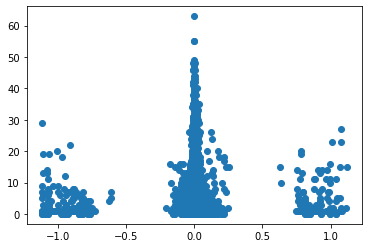

In [10]:
x = []
y = []

for i in diffs:
    x.append(i[0])
    y.append(i[1])

plt.scatter(x,y)

In [11]:
print(len(x))

10360


In [12]:
for k in list(n_pass.keys()):
    print(k)
    print(n_pass[k])

hamilton
[497, 220]
heidfeld
[35, 40]
rosberg
[285, 231]
alonso
[436, 364]
kovalainen
[80, 166]
raikkonen
[507, 370]
kubica
[3, 64]
glock
[32, 133]
massa
[403, 315]
trulli
[28, 61]
sutil
[144, 162]
webber
[223, 111]
button
[320, 332]
vettel
[509, 262]
barrichello
[64, 63]
liuzzi
[13, 45]
michael_schumacher
[140, 104]
rosa
[24, 68]
karthikeyan
[21, 74]
buemi
[78, 66]
alguersuari
[79, 58]
grosjean
[412, 416]
kobayashi
[154, 160]
gasly
[197, 168]
hulkenberg
[367, 380]
petrov
[114, 137]
bruno_senna
[69, 83]
chandhok
[0, 2]
maldonado
[253, 290]
resta
[207, 199]
perez
[624, 471]
ambrosio
[17, 63]
ricciardo
[582, 408]
vergne
[199, 188]
pic
[52, 107]
chilton
[24, 73]
gutierrez
[141, 230]
bottas
[344, 284]
garde
[18, 55]
jules_bianchi
[23, 95]
kevin_magnussen
[193, 376]
kvyat
[290, 271]
ericsson
[136, 272]
stevens
[6, 30]
max_verstappen
[294, 151]
nasr
[89, 131]
sainz
[348, 280]
merhi
[4, 25]
rossi
[4, 17]
jolyon_palmer
[57, 114]
wehrlein
[59, 111]
haryanto
[5, 40]
vandoorne
[59, 80]
ocon
[143,

In [13]:
for k in list(v_pass.keys()):
    print(k)
    print(v_pass[k])

hamilton
[529.46387, 224.96843]
heidfeld
[34.71564, 39.99321]
rosberg
[285.46506, 233.88216]
alonso
[437.4763, 364.67856]
kovalainen
[79.64251, 167.3637]
raikkonen
[503.03386, 368.30901]
kubica
[3.65552, 68.188]
glock
[32.07077, 135.51806]
massa
[399.29593, 315.02822]
trulli
[27.17611, 61.58519]
sutil
[143.56275, 163.30836]
webber
[220.00569, 110.49847]
button
[318.70218, 338.40948]
vettel
[524.05803, 262.86114]
barrichello
[63.71425, 63.61802]
liuzzi
[13.05351, 45.79457]
michael_schumacher
[138.69576, 103.75036]
rosa
[24.02872, 69.31779]
karthikeyan
[21.29236, 75.67161]
buemi
[77.80858, 66.19095]
alguersuari
[78.76069, 57.93528]
grosjean
[419.56261, 420.65392]
kobayashi
[151.7397, 160.11457]
gasly
[201.25634, 167.36053]
hulkenberg
[363.29647, 377.51331]
petrov
[113.20611, 137.84284]
bruno_senna
[67.77713, 82.9378]
chandhok
[0, 2.05234]
maldonado
[259.42619, 301.54694]
resta
[205.16345, 199.76662]
perez
[619.79088, 468.26871]
ambrosio
[16.72803, 63.6251]
ricciardo
[581.38068, 415.54785